In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
from sklearn.cluster import KMeans
import re


In [2]:
# lets load data
txt_file = "vrp data.txt"
data = []
with open(txt_file, "r") as file:
    lines = file.readlines()  # Read all lines in the file
    column_parsed = False
    column_names = []
    if column_parsed == False:
        # Extract column names from first line
        words = re.findall("\S+", lines[0])
        for word in words:
            column_names.append(word)
        column_parsed = True

    for line in lines[1:]:  # Loop through lines, skipping the first line
        # Extract data points from line
        dataline = re.findall("\S+", line)
        line_dict = {}
        for i, point in enumerate(dataline):
            # Convert data point to float and store in dictionary
            line_dict[column_names[i]] = float(point)
        data.append(line_dict)  # Append dictionary to list of data

# Create pandas dataframe from list of dictionaries
customers_df = pd.DataFrame(data)


In [3]:
DEPOT = customers_df[:1]

In [4]:
DEPOT

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,35.0,35.0,0.0,0.0,230.0,0.0


In [5]:
customers_df = customers_df[1:]

In [6]:
#getting distance from depot for all points 
def get_distance_between_two_points(x1,y1,x2,y2):
    x_diff = x2-x1
    y_diff = y2-y1

    dist = math.sqrt(math.pow(x_diff, 2) + math.pow(y_diff, 2))
    return dist



In [7]:
customers_df["distance_FROM_DEPOT"] = customers_df.apply(lambda x: get_distance_between_two_points(x["XCOORD"],x["YCOORD"],DEPOT.loc[0,"XCOORD"], DEPOT.loc[0,"YCOORD"]), axis=1)


In [8]:
customers_df["distance_FROM_DEPOT"]

1      15.231546
2      18.000000
3      22.360680
4      25.000000
5      20.615528
         ...    
96     15.264338
97     17.204651
98     21.260292
99     17.492856
100    24.041631
Name: distance_FROM_DEPOT, Length: 100, dtype: float64

In [9]:
customers_df.head()

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT
1,2.0,41.0,49.0,10.0,161.0,171.0,10.0,15.231546
2,3.0,35.0,17.0,7.0,50.0,60.0,10.0,18.000000
3,4.0,55.0,45.0,13.0,116.0,126.0,10.0,22.360680
4,5.0,55.0,20.0,19.0,149.0,159.0,10.0,25.000000
5,6.0,15.0,30.0,26.0,34.0,44.0,10.0,20.615528


In [10]:
def cluster_df(customers_df,n_clusters):
    #clustering data using machine learning algorithm to cluster data 

    columns_to_cluster = ["DUE_DATE",'XCOORD', 'YCOORD','distance_FROM_DEPOT']

    # Normalize the data
    data_norm = (customers_df[columns_to_cluster] -
                    customers_df[columns_to_cluster].mean()) / customers_df[columns_to_cluster].std()

    kmeans = KMeans(n_clusters=n_clusters).fit(data_norm)

    customers_df['cluster'] = kmeans.labels_
    # Sort points by distance from depot within each cluster
    customers_df = customers_df.sort_values(["cluster","READY_TIME", "distance_FROM_DEPOT"])
    return customers_df


In [11]:
customers_df = cluster_df(customers_df,30)

In [12]:
customers_df.head(5)

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT,cluster
40,41.0,40.0,25.0,9.0,85.0,95.0,10.0,11.180340,0
53,54.0,37.0,31.0,14.0,95.0,105.0,10.0,4.472136,0
6,7.0,25.0,30.0,3.0,99.0,109.0,10.0,11.180340,0
94,95.0,26.0,27.0,27.0,100.0,110.0,10.0,12.041595,0
33,34.0,53.0,52.0,11.0,37.0,47.0,10.0,24.758837,1


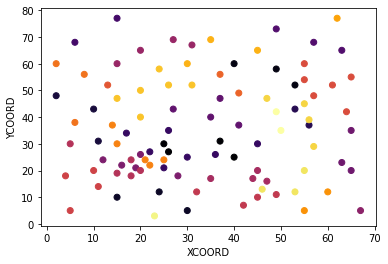

In [13]:
import matplotlib.pyplot as plt


plt.scatter(customers_df["XCOORD"],customers_df["YCOORD"],c=customers_df['cluster'],cmap="inferno")
plt.xlabel('XCOORD')
plt.ylabel('YCOORD')

plt.show()


In [14]:
class Route:
    def  __init__(self,customers_df):
        self.customers_df = customers_df
        self.route_no = self.customers_df["cluster"].to_list()[0]        
        self.n_customers = self.customers_df.shape[0]
        self.calculate_distance_matrix()

    def calculate_distance_matrix(self):
        self.dist_matrix = np.zeros((self.n_customers, self.n_customers))
        # Loop over each pair of customers
        for i in range(self.n_customers):
            for j in range(self.n_customers):
                # Calculate the Euclidean distance between the XCOORD and YCOORD values of the two customers
                x_diff = self.customers_df['XCOORD'][i] - \
                    self.customers_df['XCOORD'][j]
                y_diff = self.customers_df['YCOORD'][i] - \
                    self.customers_df['YCOORD'][j]
                dist = math.sqrt(math.pow(x_diff, 2) + math.pow(y_diff, 2))

                # Store the calculated distance in the corresponding position in the distance matrix
                self.dist_matrix[i][j] = dist

        return self.dist_matrix


    def get_total_distance(self):
              # distance between customers + distance between boundary customers and DEPOT
        distances = []
        if self.n_customers > 0:
            for i, customer in self.customers_df.iterrows():

                if i+1 >= self.n_customers:
                    continue

                next_customer = self.customers_df.iloc[i+1]
                distance_between_cust_next_customer = get_distance_between_two_points(
                    customer["XCOORD"], customer["YCOORD"], next_customer["XCOORD"], next_customer["YCOORD"])
                distances.append(distance_between_cust_next_customer)

            # distance between DEPOT and boundry customers
            b1 = self.customers_df.iloc[0]
            distance_between_b1_DEPOT = get_distance_between_two_points(
                b1["XCOORD"], b1["YCOORD"], DEPOT["XCOORD"], DEPOT["YCOORD"])
            distances.append(distance_between_b1_DEPOT)

            b2 = self.customers_df.iloc[-1]
            distance_between_b2_DEPOT = get_distance_between_two_points(
                b2["XCOORD"], b2["YCOORD"], DEPOT["XCOORD"], DEPOT["YCOORD"])
            distances.append(distance_between_b2_DEPOT)

            self.distance = 0
            for distance in distances:
                self.distance += distance

            return self.distance
        else:
            self.distance = 0
            return self.distance


    def check_capacity(self):
        self.load =0
        self.capacity_constrain = True
        for i,v in self.customers_df.iterrows():
            self.load +=v["DEMAND"]
        
        if self.load<=200:
            self.capacity_constrain = True
            return True
        else:
            self.capacity_constrain = False
            return False

    def check_time_constrain(self):
        self.time_constrain = True
        self.current_time = self.customers_df.loc[0,"READY_TIME"]
        for i,v in self.customers_df.iterrows():
            if self.current_time>v["DUE_DATE"]:
                #means that current time exceeded the upper constrain for serving the customer
                self.time_constrain = False
            elif self.current_time<=v["DUE_DATE"]:
                pass
            else:
                print("condition fails")
            
        return self.time_constrain

    def get_no_of_customers(self):
        return self.n_customers

    def sort_route(self):
        self.get_total_distance()
        self.check_capacity()
        self.check_time_constrain()
        self.customers_df = self.customers_df.sort_values(["cluster","READY_TIME", "distance_FROM_DEPOT"])

    def fitness(self):
        # calculate route fitness 
        self.check_capacity()
        self.check_time_constrain()
        self.get_total_distance()
        
        if self.capacity_constrain:
            f1 = 1000
        else:
            f1 = 0 
        
        if self.time_constrain:
            f2 = 1000
        else:
            f2 = 0

        self.fitness_value = f1*f2
        return self.fitness_value


    def mutate(self, mutation_rate):
        # randomly decide if mutation occurs based on mutation_rate
        if np.random.rand() > mutation_rate:
            return
        
        # randomly select two distinct customers to swap their positions
        i, j = np.random.choice(self.n_customers, size=2, replace=False)
        
        # swap the positions of the two customers
        self.customers_df.iloc[i], self.customers_df.iloc[j] = self.customers_df.iloc[j], self.customers_df.iloc[i]

        # sort the route after mutation
        self.sort_route()

        # check if the new solution is feasible, otherwise revert back to the original solution
        if not self.check_capacity() or not self.check_time_constrain():
            self.customers_df.iloc[i], self.customers_df.iloc[j] = self.customers_df.iloc[j], self.customers_df.iloc[i]
            self.sort_route()


In [15]:
customers_df[customers_df["cluster"]==0].reset_index().drop(columns="index")

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME,distance_FROM_DEPOT,cluster
0,41.0,40.0,25.0,9.0,85.0,95.0,10.0,11.180340,0
1,54.0,37.0,31.0,14.0,95.0,105.0,10.0,4.472136,0
2,7.0,25.0,30.0,3.0,99.0,109.0,10.0,11.180340,0
3,95.0,26.0,27.0,27.0,100.0,110.0,10.0,12.041595,0


In [16]:
DEPOT

,CUST_NO,XCOORD,YCOORD,DEMAND,READY_TIME,DUE_DATE,SERVICE_TIME
0,1.0,35.0,35.0,0.0,0.0,230.0,0.0


In [17]:
def get_routes(customers_df,n_clusters):
    routes = []
    for n in range(n_clusters):
        routes.append(Route(customers_df[customers_df["cluster"]==n].reset_index().drop(columns="index")))

    return routes

In [18]:
n_clusters=30

In [19]:
routes= get_routes(customers_df,n_clusters)

In [20]:
for route in routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},check time = {route.check_time_constrain()}")

route:0, total distance = 45.13401063775129,check capacity = True,check time = True
route:1, total distance = 76.16854282171906,check capacity = True,check time = True
route:2, total distance = 80.9398429775898,check capacity = True,check time = True
route:3, total distance = 92.99408383921342,check capacity = True,check time = True
route:4, total distance = 47.500942645820565,check capacity = True,check time = True
route:5, total distance = 95.44224989488538,check capacity = True,check time = True
route:6, total distance = 103.17850073278748,check capacity = True,check time = True
route:7, total distance = 106.25612971612398,check capacity = True,check time = True
route:8, total distance = 44.562571660022144,check capacity = True,check time = True
route:9, total distance = 91.16963714654892,check capacity = True,check time = True
route:10, total distance = 73.81301718358466,check capacity = True,check time = True
route:11, total distance = 87.72684879784524,check capacity = True,check

In [21]:
for route in routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},check time = {route.check_time_constrain()}")

route:0, total distance = 45.13401063775129,check capacity = True,check time = True
route:1, total distance = 76.16854282171906,check capacity = True,check time = True
route:2, total distance = 80.9398429775898,check capacity = True,check time = True
route:3, total distance = 92.99408383921342,check capacity = True,check time = True
route:4, total distance = 47.500942645820565,check capacity = True,check time = True
route:5, total distance = 95.44224989488538,check capacity = True,check time = True
route:6, total distance = 103.17850073278748,check capacity = True,check time = True
route:7, total distance = 106.25612971612398,check capacity = True,check time = True
route:8, total distance = 44.562571660022144,check capacity = True,check time = True
route:9, total distance = 91.16963714654892,check capacity = True,check time = True
route:10, total distance = 73.81301718358466,check capacity = True,check time = True
route:11, total distance = 87.72684879784524,check capacity = True,check

In [22]:
for route in routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},check time = {route.check_time_constrain()}")

route:0, total distance = 45.13401063775129,check capacity = True,check time = True
route:1, total distance = 76.16854282171906,check capacity = True,check time = True
route:2, total distance = 80.9398429775898,check capacity = True,check time = True
route:3, total distance = 92.99408383921342,check capacity = True,check time = True
route:4, total distance = 47.500942645820565,check capacity = True,check time = True
route:5, total distance = 95.44224989488538,check capacity = True,check time = True
route:6, total distance = 103.17850073278748,check capacity = True,check time = True
route:7, total distance = 106.25612971612398,check capacity = True,check time = True
route:8, total distance = 44.562571660022144,check capacity = True,check time = True
route:9, total distance = 91.16963714654892,check capacity = True,check time = True
route:10, total distance = 73.81301718358466,check capacity = True,check time = True
route:11, total distance = 87.72684879784524,check capacity = True,check

In [23]:
class Solution:
    def __init__(self,routes_list):
        self.routes = routes_list
        self.get_total_solution_distance()
        self.get_total_number_of_served_customers()
        self.get_number_of_routes()
        self.check_feasiblity()

    def get_total_solution_distance(self):
        self.solution_total_distance =0
        for route in self.routes:
            self.solution_total_distance+=route.get_total_distance()
        return self.solution_total_distance
    
    def get_total_number_of_served_customers(self):
        self.total_n_customers = 0
        for route in self.routes.copy():
            if route.get_no_of_customers()<=1:
                # self.routes.remove(route)
                pass
            else:
                self.total_n_customers+=route.get_no_of_customers()
        return self.total_n_customers
    
    def get_number_of_routes(self):
        self.no_of_routes = len(self.routes) #equalivent to no. of vehicles as well
        
    def check_feasiblity(self):
        self.feasiblity = True
        for route in self.routes:
            if route.fitness():
                pass
            else:
                self.feasiblity = False
        return self.feasiblity 

    def merge_routes(self,route1,route2):
        #merge_route? 
        #get customers df from the two routes 
        routes = self.routes.copy()
        route1_customers = route1.customers_df
        route2_customers = route2.customers_df

        #merge the two customers 
        merged_customers = pd.concat([route1_customers,route2_customers],ignore_index=True)

        #rename the cluster to be as the first route cluster
        merged_customers["cluster"] = route1_customers.loc[0,"cluster"]

        #create new route obj 
        new_route = Route(merged_customers)
        new_route.sort_route()
        if route1 in routes:
            routes.remove(route1)
        else:
            print("route1 not in self.routes")

        if route2 in routes:
            routes.remove(route2)
        else:
            print("route2 not in self.routes")
        routes.append(new_route)
        
        self.routes = routes.copy()
        self.get_total_solution_distance()
        self.get_total_number_of_served_customers()
        self.get_number_of_routes()
        self.check_feasiblity()

        return new_route
    
    def fitness_func(self):
        capacity_constrain = 1
        time_constrain = 1

        for route in self.routes:
            if not route.check_capacity():
                capacity_constrain = 0 
            if not route.check_time_constrain():
                time_constrain = 0


        fitness_value = capacity_constrain*time_constrain*(self.total_n_customers*100000-self.no_of_routes*50000-self.solution_total_distance)

        return round(fitness_value,2)
            
    def remove_unfeasible_routes(self):
        routes = self.routes.copy()
        for route in self.routes:
            if route.fitness()==0:
                routes.remove(route)
            
        self.routes = routes.copy()
        self.check_feasiblity()
                            
                
    def merge_two_routes_with_least_capacity(self):
        for route in self.routes:
            route.sort_route()

        routes = self.routes.copy()
        sorted_by_load = sorted(routes, key=lambda x: x.load)
        route1 = sorted_by_load[0]
        route2 = sorted_by_load[1]
        self.merge_routes(route1, route2) 

    def merge_two_routes_with_smallest_distance(self):
        for route in self.routes:
            route.sort_route()

        routes = self.routes.copy()
        sorted_by_load = sorted(routes, key=lambda x: x.distance)
        route1 = sorted_by_load[0]
        route2 = sorted_by_load[1]
        self.merge_routes(route1, route2) 


In [24]:
len(routes)

30

In [25]:
sol = Solution(routes)

In [26]:
for route in sol.routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},capacity = {route.load},check time = {route.check_time_constrain()}")

route:0, total distance = 45.13401063775129,check capacity = True,capacity = 53.0,check time = True
route:1, total distance = 76.16854282171906,check capacity = True,capacity = 42.0,check time = True
route:2, total distance = 80.9398429775898,check capacity = True,capacity = 33.0,check time = True
route:3, total distance = 92.99408383921342,check capacity = True,capacity = 17.0,check time = True
route:4, total distance = 47.500942645820565,check capacity = True,capacity = 20.0,check time = True
route:5, total distance = 95.44224989488538,check capacity = True,capacity = 99.0,check time = True
route:6, total distance = 103.17850073278748,check capacity = True,capacity = 39.0,check time = True
route:7, total distance = 106.25612971612398,check capacity = True,capacity = 48.0,check time = True
route:8, total distance = 44.562571660022144,check capacity = True,capacity = 47.0,check time = True
route:9, total distance = 91.16963714654892,check capacity = True,capacity = 11.0,check time = Tr

In [27]:
len(sol.routes)

30

In [28]:
len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func()


(30, 2364.290905882183, 96, True, 8097635.71)

In [29]:
#use this initial solution in genetic algorithm 
initial_solution = sol

In [30]:
def generate_initial_population(customers_df,POPULATION_SIZE,n_clusters):
        # Step 1: Generate initial population
        population = []
        for i in range(POPULATION_SIZE):
            customers_df_generated = cluster_df(customers_df, n_clusters)
            routes = get_routes(customers_df_generated, n_clusters)
            sol = Solution(routes)
            len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func()
            population.append(sol)
        return population


In [31]:
pop = generate_initial_population(customers_df, 50,n_clusters)

In [32]:
for sol in pop:
    print(len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func())


30 2391.6020750741586 97 True 8197608.4
30 2410.0820412746793 98 True 8297589.92
30 2381.6938920435214 96 True 8097618.31
30 2362.7802513611705 96 True 8097637.22
30 2415.715945368002 96 True 8097584.28
30 2416.2000960843575 96 True 8097583.8
30 2366.7671446423137 97 True 8197633.23
30 2435.9099706879983 96 True 8097564.09
30 2401.153043839529 97 True 8197598.85
30 2376.689000480229 97 True 8197623.31
30 2397.4060153949113 97 True 8197602.59
30 2404.5767708951194 96 True 8097595.42
30 2421.290715199736 97 True 8197578.71
30 2383.375895334052 96 True 8097616.62
30 2335.47799145015 96 True 8097664.52
30 2343.8028298596564 97 True 8197656.2
30 2315.814956146974 98 True 8297684.19
30 2362.2697327180904 98 True 8297637.73
30 2390.7522016992457 96 True 8097609.25
30 2375.4756200169477 97 True 8197624.52
30 2437.0524532209383 97 True 8197562.95
30 2403.588519891142 97 True 8197596.41
30 2410.7952238964954 97 True 8197589.2
30 2362.641365688627 96 True 8097637.36
30 2356.945137772502 97 True 8

In [33]:
import random

def rank_based_selection(population, k=2):
    fitness_list = [sol.fitness_func() for sol in population]
    ranked_list = sorted(range(len(fitness_list)), key=lambda k: fitness_list[k])
    ranks = [len(fitness_list) - i for i in ranked_list]
    probs = [rank / sum(ranks) for rank in ranks]
    selected_indices = random.choices(range(len(population)), weights=probs, k=k)
    return [population[i] for i in selected_indices]


In [34]:
parent1,parent2 = rank_based_selection(pop,2)

In [35]:
for sol in rank_based_selection(pop,2):
    print(len(sol.routes),sol.get_total_solution_distance(),sol.get_total_number_of_served_customers(),sol.check_feasiblity(),sol.fitness_func())


30 2410.7952238964954 97 True 8197589.2
30 2387.830319647049 96 True 8097612.17


In [36]:
for route in parent1.routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},capacity = {route.load},check time = {route.check_time_constrain()}")

route:0, total distance = 60.546107730135816,check capacity = True,capacity = 60.0,check time = True
route:1, total distance = 56.213861581321126,check capacity = True,capacity = 34.0,check time = True
route:2, total distance = 72.67898579587732,check capacity = True,capacity = 33.0,check time = True
route:3, total distance = 119.23556028251735,check capacity = True,capacity = 87.0,check time = True
route:4, total distance = 87.80067498282912,check capacity = True,capacity = 85.0,check time = True
route:5, total distance = 68.24099559961356,check capacity = True,capacity = 52.0,check time = True
route:6, total distance = 99.90181672017059,check capacity = True,capacity = 51.0,check time = True
route:7, total distance = 83.32123880404372,check capacity = True,capacity = 35.0,check time = True
route:8, total distance = 37.72354365436401,check capacity = True,capacity = 32.0,check time = True
route:9, total distance = 98.4363251688913,check capacity = True,capacity = 85.0,check time = Tru

In [37]:
for route in parent2.routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},capacity = {route.load},check time = {route.check_time_constrain()}")

route:0, total distance = 91.16963714654892,check capacity = True,capacity = 11.0,check time = True
route:1, total distance = 112.58403900041844,check capacity = True,capacity = 85.0,check time = True
route:2, total distance = 44.45967868697908,check capacity = True,capacity = 56.0,check time = True
route:3, total distance = 81.5441521406812,check capacity = True,capacity = 98.0,check time = True
route:4, total distance = 82.07744514047423,check capacity = True,capacity = 39.0,check time = True
route:5, total distance = 76.16854282171906,check capacity = True,capacity = 42.0,check time = True
route:6, total distance = 67.25725344183368,check capacity = True,capacity = 72.0,check time = True
route:7, total distance = 99.90181672017059,check capacity = True,capacity = 51.0,check time = True
route:8, total distance = 146.64365509883748,check capacity = True,capacity = 106.0,check time = True
route:9, total distance = 68.35202996254024,check capacity = True,capacity = 7.0,check time = True

In [38]:
def create_offspring(parent1, parent2, crossover_rate):
    # check if crossover should occur
    if random.random() > crossover_rate:
        # if not, return a clone of parent1 or parent2 at random
        if random.random() < 0.5:
            return parent1.clone()
        else:
            return parent2.clone()

    p1_routes = parent1.routes
    p2_routes = parent2.routes

    # Choose a random crossover point
    crossover_point = random.randint(1, len(p1_routes) - 1)

    # Create the offspring by combining the parents' genetic material
    offspring_routes = p1_routes[:crossover_point] + p2_routes[crossover_point:]
    offspring = Solution(offspring_routes)

    return offspring


In [39]:
offspring = create_offspring(parent1,parent2,0.8)

In [40]:
print(len(offspring.routes),offspring.get_total_solution_distance(),offspring.get_total_number_of_served_customers(),offspring.check_feasiblity(),offspring.fitness_func())


30 2410.294307208857 96 True 8097589.71


In [41]:
for route in offspring.routes:
    print(f"route:{route.route_no}, total distance = {route.get_total_distance()},check capacity = {route.check_capacity()},capacity = {route.load},check time = {route.check_time_constrain()}")

route:0, total distance = 60.546107730135816,check capacity = True,capacity = 60.0,check time = True
route:1, total distance = 112.58403900041844,check capacity = True,capacity = 85.0,check time = True
route:2, total distance = 44.45967868697908,check capacity = True,capacity = 56.0,check time = True
route:3, total distance = 81.5441521406812,check capacity = True,capacity = 98.0,check time = True
route:4, total distance = 82.07744514047423,check capacity = True,capacity = 39.0,check time = True
route:5, total distance = 76.16854282171906,check capacity = True,capacity = 42.0,check time = True
route:6, total distance = 67.25725344183368,check capacity = True,capacity = 72.0,check time = True
route:7, total distance = 99.90181672017059,check capacity = True,capacity = 51.0,check time = True
route:8, total distance = 146.64365509883748,check capacity = True,capacity = 106.0,check time = True
route:9, total distance = 68.35202996254024,check capacity = True,capacity = 7.0,check time = Tru

In [43]:
n_generation = 300
n_population = 100 
co_rate = 0.8
m_rate = 0.3
n_clusters = 20

# Generate initial population
pop = generate_initial_population(customers_df, n_population, n_clusters)

for i in range(n_generation):
    print(f"Generation {i}")
    
    # Rank-based selection
    parents = rank_based_selection(pop, 2)
    
    # Create offspring using crossover
    offspring = create_offspring(parents[0], parents[1], co_rate)
    
    # Mutate offspring
    for route in offspring.routes:
        if random.random() < m_rate:
            while not route.mutate(0.3):
                pass
                
    # Calculate fitness for offspring
    offspring_fitness = offspring.fitness_func()
    
    # Replace worst solution in population with offspring
    pop_fitness = [sol.fitness_func() for sol in pop]
    worst_idx = pop_fitness.index(min(pop_fitness))
    if offspring_fitness > pop_fitness[worst_idx]:
        pop[worst_idx] = offspring


Generation 0


In [ ]:
n_generation = 300
n_population = 100 
co_rate = 0.8
m_rate = 0.3
n_clusters = 20
for i in range(n_generation):
    print(f"generation:{i}")
    for j in range(n_population):
        pop = generate_initial_population(customers_df,POPULATION_SIZE,n_clusters)
        parent1,parent2 = rank_based_selection(pop,2)
        offspring = create_offspring(parent1, parent2, co_rate)
        for route in offspring.routes:
            route.mutate()
